# 1. Load the data file and libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn import neighbors, linear_model
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import classification_report
%matplotlib inline

red_wine = pd.read_csv("winequality-red.csv", sep=';')

# 2. Construct a new binary column indicating whether the wine is good or not

In [2]:
original_outcome = red_wine['quality'].values

good_wine = original_outcome >= 6 # this converts values to either true or false
# convert to 0 and 1
good_wine = good_wine*1

# 3. Normalize the data

An issue with this dataset is the different scales used to measure the input variables;
for example chlorides (ranges between 0.012 and 0.6)and total sulfur dioxide (ranges between 6 and 289).
As a result, we need to scale/standardize the input data.

We plot the histograms of all the columns in our data set to highlight this issue.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1173b8278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119c225f8>]], dtype=object)

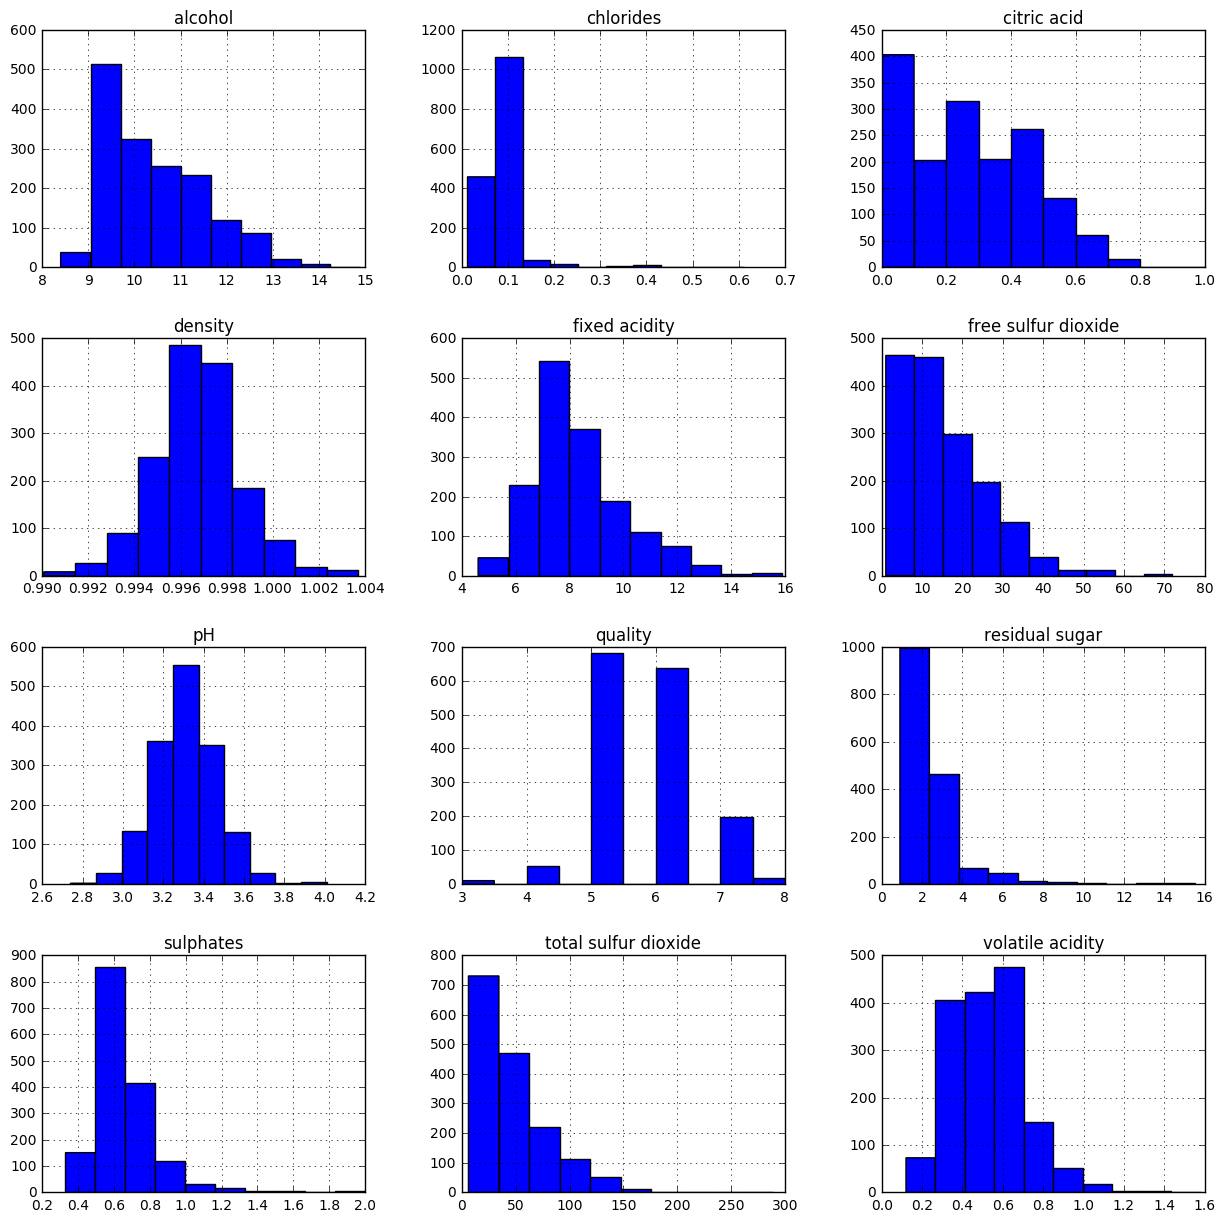

In [3]:
pd.DataFrame.hist(red_wine, figsize=[15,15])

In [4]:
# remove the outcome variable and keep only the input variables
input_cols = list(red_wine.ix[:, red_wine.columns != 'quality'].columns)


In [5]:
# compute the z-score for all input variables
red_transform = pd.DataFrame()
for col in input_cols:
    red_transform[col + '_zscore'] = (red_wine[col] - red_wine[col].mean()) / red_wine[col].std()

predictors_z = red_transform.values

The data is now normalized centered around zero (mean = 0) with standard deviation = 1.

# 4. Split the data into random training and test subsets

In [6]:
Z_train, Z_test, y_train, y_test = train_test_split(predictors_z, good_wine,
                                                    test_size=0.5,
                                                    random_state=42)

# 5. Train the k-Nearest Neighbours classifiers

In [7]:
acc_dict = dict()
for i in np.arange(1, 500, 5):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(Z_train, y_train)

# 6. Evaluate each classifier using 5-fold cross validation

We will get 5 folds, each with 320 points used for validation and 1280 used for training the data.
For each k, we find the average accuracy of all the folds and then we choose the k with the highest accuracy.

In [8]:
# 5-fold cross validation with k = 5
kfold = KFold(1599, n_folds=5)
#for iteration, data in enumerate(kfold, start=1):
#    print(iteration, data[0], data[1])

# find accuracy of all ks
scores_dict = dict()
for i in np.arange(1, 500, 5):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    # use classification accuracy as the evaluation metric
    scores = cross_val_score(knn, predictors_z, good_wine, cv=5, scoring='accuracy')
    #print(scores)
    #print(scores.mean())
    scores_dict[i] = round(float(scores.mean()),3)

## Optimal k

In [9]:
max(scores_dict, key=scores_dict.get)

111

## Cross-Validated accuracy for optimal k

In [10]:
scores_dict[max(scores_dict, key=scores_dict.get)]

0.735

# 7. Predict the generalisation error using the test data set

In [15]:
knn = neighbors.KNeighborsClassifier(n_neighbors=max(scores_dict, key=scores_dict.get))
model = knn.fit(Z_train, y_train)
y_true, y_pred = y_test, model.predict(Z_test)
#print(classification_report(y_true, y_pred))
error = 1 - model.score(Z_test, y_test)
print(error) #Generalisation Errors

0.28125


## Confusion Matrix

In [12]:
conf1 = sum((y_pred == 1) & (y_true == 1))
conf2 = sum((y_pred == 0) & (y_true == 1))
conf3 = sum((y_pred == 1) & (y_true == 0))
conf4 = sum((y_pred == 0) & (y_true == 0))
    
conf = pd.DataFrame([[conf1,conf2],[conf3,conf4]])
conf.columns = ['Good','Bad']
conf.rename({0:'Good',1:'Bad'}, inplace = True)

print(conf)

      Good  Bad
Good   332   82
Bad    143  243
